In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd

plt.rcParams["figure.facecolor"] = "w"

## Appendix: add dataset

In [3]:
fname = "./burst_info_data.pkl"

with open(fname, "rb") as fp:
    burst_info = pkl.load(fp)
print(burst_info.keys())

df_burst = pd.DataFrame(burst_info)
df_burst["cluster_id"] += 1

dict_keys(['burst_f', 'burst_range', 'burst_amp', 'cluster_id', 'pop_type'])


In [4]:
nc = 1
pop_type = 0


def read_burst(df, target_cluster_id=0, target_pop_type=-1):
    cond = (df["cluster_id"] == target_cluster_id) & (df["pop_type"] == target_pop_type)
    burst = dict()
    burst["burst_amp"] = get_attrib(df, "burst_amp", cond)
    burst["burst_f"] = get_attrib(df, "burst_f", cond)
    burst_range = get_attrib(df, "burst_range", cond)
    if burst_range.shape[0] > 0:
        burst["burst_duration"] = burst_range[:, 1] - burst_range[:, 0]
    else:
        burst["burst_duration"] = [-1]
    return burst


def get_attrib(df, attrib_name, condition):
    df_sub = df[condition]
    attrib = []
    for arr in df_sub[attrib_name]:
        attrib.extend(arr)
    return np.array(attrib)


burst_sub = read_burst(df_burst, target_cluster_id=1, target_pop_type=0)

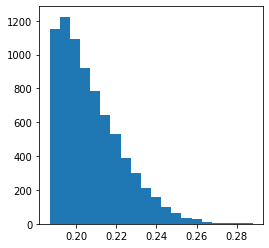

In [5]:
plt.figure(figsize=(4,4))
plt.hist(burst_sub["burst_amp"], 20)
plt.show()

In [6]:
def draw_hist(df, target_cluster_id, figsize=(9, 3.5), dpi=120,
              f_range=(10, 100), amp_range=(0.1, 0.3), t_range=(0., 1), nbin=40,
              norm=False):
    
    keys = ("burst_f", "burst_amp", "burst_duration")
    key_range = (f_range, amp_range, t_range)
    key_labels = (r"$f_{center}$ (Hz)", r"$\langle A \rangle$", r"$T$ (s)")
    cs = ("r", "b")
    pop_labels = (r"$Fast$", r"$Slow$")
    
    num_burst = []
    fig, axs = plt.subplots(1, 3, figsize=figsize, dpi=dpi)
    for n in range(2):
        burst_sub = read_burst(df_burst, target_cluster_id=target_cluster_id, target_pop_type=n)
        num_burst.append(len(burst_sub["burst_f"]))
        for i in range(3):
            r = key_range[i]
            edges = np.linspace(r[0], r[1], nbin)
            
            if keys[i] == "burst_duration":
                dt = 0.15
                edges = np.arange(r[0], r[1]+dt/2, dt)
                
            hist_bin, _ = np.histogram(burst_sub[keys[i]], bins=edges, density=False)
            if norm:
                hist_bin = np.array(hist_bin) / np.sum(hist_bin)
            
            x = (edges[1:] + edges[:-1])/2
            axs[i].plot(x, hist_bin, '.--', lw=1, ms=5, c=cs[n], label=pop_labels[n])
            axs[i].set_xlabel(key_labels[i], fontsize=13)
    
    for i in range(3):
        axs[i].legend(loc="upper right")
        
    plt.suptitle("Cluster id = %d (# burst = %d(F),%d(S))"%(target_cluster_id, num_burst[0], num_burst[1]),
                 fontsize=14, weight="bold")
        
    plt.tight_layout()
    return fig
    

In [53]:
K = len(df_burst["cluster_id"].unique())
range_set = [{} for _ in range(K+1)]
for nc in range(1, K):
    range_set[nc]["f_range"] = (10, 90)
    range_set[nc]["amp_range"] = (0.17, 0.3)
    range_set[nc]["t_range"] = (0, 1.2)

# hard fix
range_set[5]["amp_range"]  = (0.5, 1.2)
range_set[6]["amp_range"]  = (0.28, 0.7)
range_set[7]["amp_range"]  = (0.28, 0.7)
range_set[8]["amp_range"]  = (0.5, 1.2)
range_set[9]["amp_range"]  = (0.28, 0.7)
range_set[10]["amp_range"] = (0.28, 0.7)
range_set[11]["amp_range"] = (0.5, 1.2)
range_set[12]["amp_range"] = (0.5, 1.2)
range_set[13]["amp_range"] = (0.5, 1.2)
range_set[14]["amp_range"] = (0.5, 1.2)
range_set[15]["amp_range"] = (0.5, 1.2)

In [ ]:
for nc in range(1, K+1):
    fig = draw_hist(df_burst, nc, norm=True, **range_set[nc], nbin=35)
    fig.savefig("./figs/burst_info_%02d.png"%(nc), dpi=150)

## Check individual

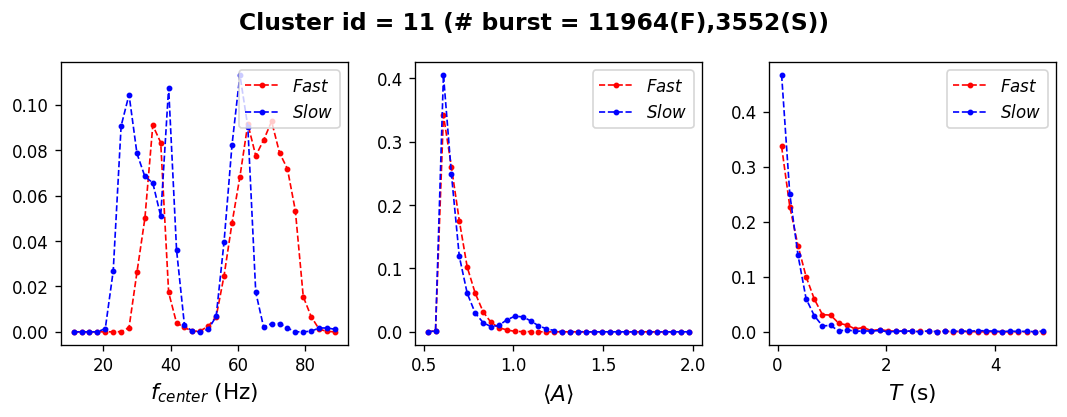

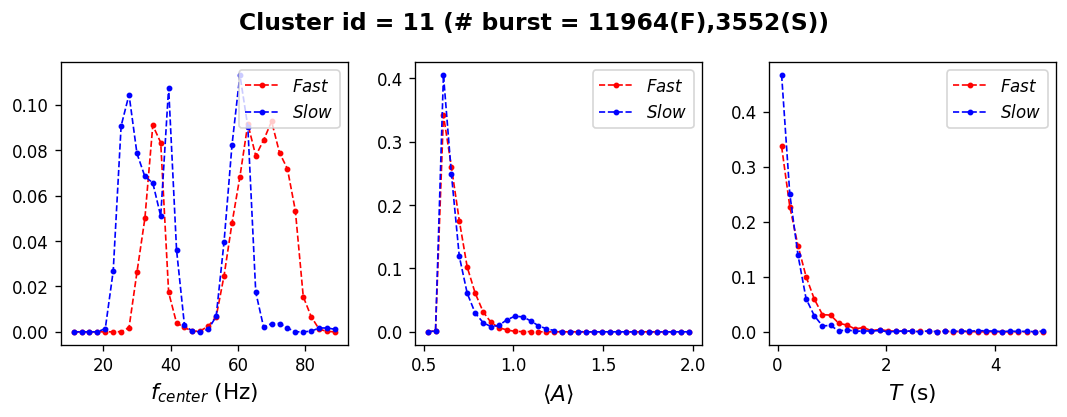

In [151]:
nc = 11

range_tmp = {
    "f_range": (10, 90),
    "amp_range": (0.5, 2),
    "t_range": (0, 5)
}

draw_hist(df_burst, nc, norm=True, **range_tmp, nbin=35)

In [97]:
import sys
sys.path.append("../../include/")

import hhsignal
import hhtools
import burst_tools as bt

summary_obj = hhtools.SummaryLoader("../data/")
with open("./th_data.pkl", "rb") as fp:
    th_buf = pkl.load(fp)
print(th_buf["std_ratio"])

3.29


In [102]:
reload(bt)

<module 'burst_tools' from '/home/jungyoung/Project/hh_neuralnet/gen_three_pop_samples/multifreq_burst/burst_tools.py'>

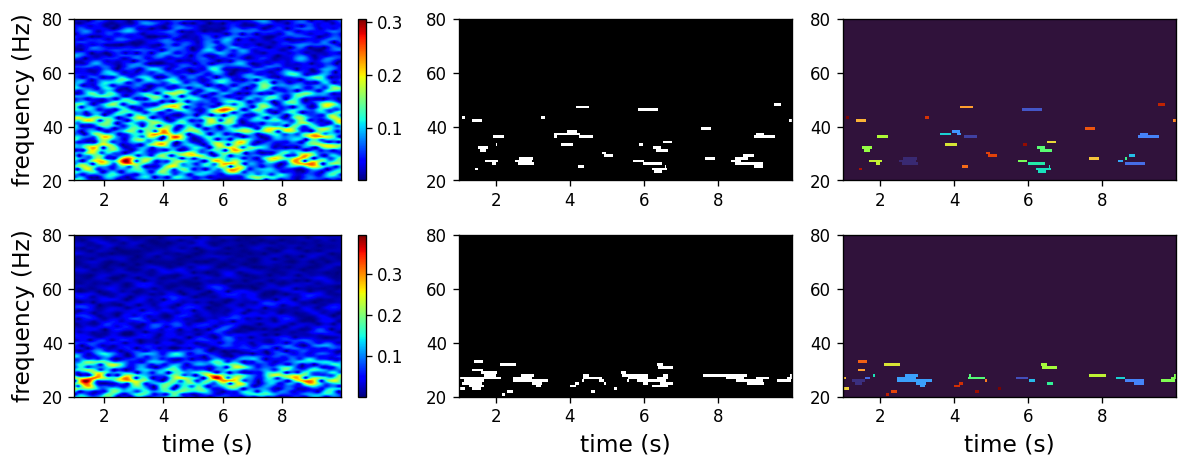

In [111]:
nc = 2
nitr = 50
flim_show = (20, 80)

flim = th_buf["psd_params"]["flim"]
wbin_t = th_buf["psd_params"]["wbin_t"]
mbin_t = th_buf["psd_params"]["mbin_t"]

nid = summary_obj.get_id(nc-1, nitr)
detail_data = summary_obj.load_detail(nc-1, nitr)

def cut_start(signal, t):
    idt = (t >= 0.5)
    return signal[idt], t[idt]

fig, axs = plt.subplots(2, 3, figsize=(10, 4), dpi=120, facecolor='w')

for tp in range(2):
    vlfp, t = cut_start(detail_data["vlfp"][tp+1], detail_data["ts"])
    psd, fpsd, tpsd = hhsignal.get_stfft(vlfp, t, 2000, mbin_t=mbin_t, wbin_t=wbin_t, frange=flim)
    
    ## old version
    pth = th_buf["th_m"][nid, tp] + 3.3 * th_buf["th_s"][nid, tp]
    # im_bin = psd >= pth
    # im_class = bt.find_blob(im_bin)
    # burst_f, burst_range, burst_amp = bt.extract_burst_attrib(psd, fpsd, im_class)
    
    burst_map = bt.find_blob_filtration(psd, th_buf["th_m"][nid, tp], th_buf["th_s"][nid, tp],
                                        std_min=3.3, std_max=8, std_step=0.1, nmin_width=int(0.05 // mbin_t))
    burst_f, burst_range, burst_amp = bt.extract_burst_attrib(psd, fpsd, burst_map)
    

    xlb = "time (s)" if tp == 1 else None
    bt.draw_binarize_psd(psd, pth, x=tpsd, y=fpsd, flim=flim_show, ylabel="frequency (Hz)", xlabel=xlb, axs=axs[tp][:2])

    plt.axes(axs[tp][2])
    hhtools.imshow_xy(burst_map, x=tpsd, y=fpsd, cmap="turbo", interpolation="none")
    
    # bt.draw_burst_attrib(im_class, burst_f, burst_range, tpsd=tpsd, fpsd=fpsd, flim=flim_show)
    
    plt.xlabel(xlb, fontsize=14)
    plt.ylim(flim_show)
    plt.tight_layout()

# plt.savefig("./figs/burst_sample.png", dpi=150)
plt.show()

In [109]:
3/100

0.03

## Filtration 

In [1]:
from importlib import reload
import burst_tools as bt
reload(bt)
import pickle as pkl
import hhsignal

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../../include/")

import hhsignal
import hhtools
import burst_tools as bt

summary_obj = hhtools.SummaryLoader("../data/")
with open("./th_data2.pkl", "rb") as fp:
    th_buf = pkl.load(fp)
print(th_buf["std_ratio"])

3.29


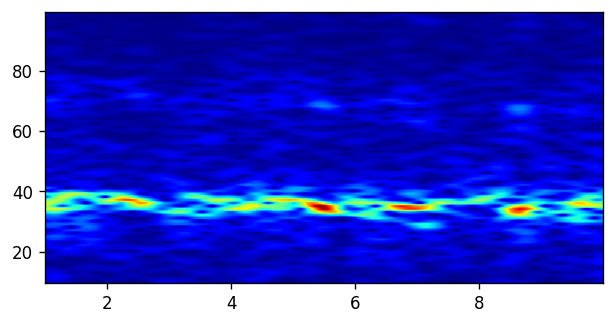

In [87]:
nc = 8
tp  = 1
nitr = 50
flim_show = (20, 80)

def cut_start(signal, t):
    idt = (t >= 0.5)
    return signal[idt], t[idt]

nid = summary_obj.get_id(nc-1, nitr)
detail_data = summary_obj.load_detail(nc-1, nitr)
vlfp, t = cut_start(detail_data["vlfp"][tp+1], detail_data["ts"])
psd, fpsd, tpsd = hhsignal.get_stfft(vlfp, t, 2000, mbin_t=0.01, wbin_t=1, frange=(10, 100))

plt.figure(dpi=120, figsize=(6, 3))
hhtools.imshow_xy(psd, x=tpsd, y=fpsd, cmap='jet')
plt.show()

In [88]:
reload(bt)
burst_map, null_map, im_b = bt.extract_burst_filtration(psd, fpsd,
                                        th_buf["th_m"][nid, tp], th_buf["th_s"][nid, tp],
                                        std_min=3.3, std_max=8, std_step=0.1,
                                        nmin_width=int(0.05/th_buf["psd_params"]["mbin_t"]))

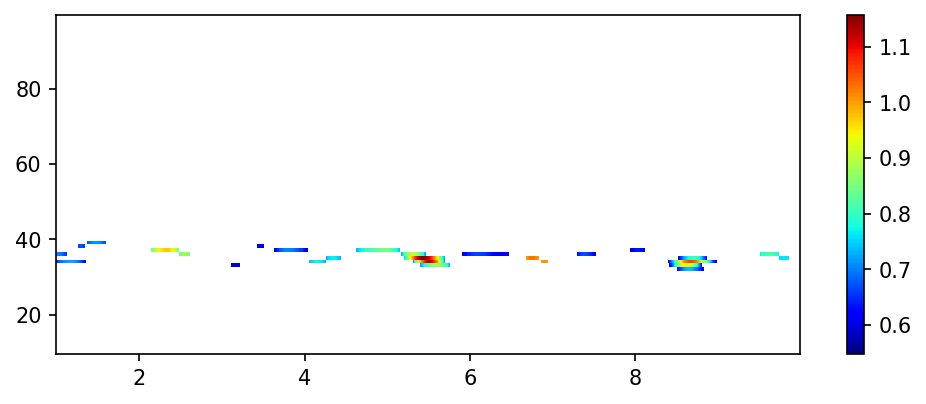

In [91]:
amap = (burst_map > 0).astype(float)
# amap[amap == 0] = 1
pth_min = th_buf["th_m"][nid, tp] + 3 * th_buf["th_s"][nid, tp]

plt.figure(dpi=150, figsize=(8, 3))
hhtools.imshow_xy(psd, alpha=amap, x=tpsd, y=fpsd, cmap="jet", interpolation="none", vmin=pth_min)
plt.colorbar()

In [95]:
width = []
for nb in range(1, np.max(burst_map)+1):
    nr, nc = np.where(burst_map == nb)
    width.append([np.max(nc) - np.min(nc)])

In [97]:
np.min(width)

7

In [65]:
test = bt.extract_burst_attrib(psd, fpsd, burst_map)